In [1]:
import sisl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import functools

# TI-03: Quantum Hall Effect
In this exercise, we will build on **TB_07** and **A_03** to simulate the quantum Hall effect. In **A_03**, we learned how to created a Hall bar device and in **TB_07**, how to deal with magnetic fields.

Here, we will extract the Hall resistance from the transmissions calculated with `TBtrans` using the Landauer-Büttiker formalism.

## Exercise Overview:
1. Create a Hall bar (see **A_03**)
2. Construct Hamiltonians and add magnetic fields (see **TB_07**)
3. Calculate the transmission with `TBtrans`
4. Extract the Hall resistance $(R_H)$.
4. Extract the logitudinal resistance $(R_L)$.

## Exercise

### 1. Create a Hall bar
In order to be able to observe the quantum Hall effect, the size of the Hall bar needs to be big enough. For a 4(6) lead device reasonable dimensions are: 
1. 4-lead device (square lattice):
   - Width of electrodes (perpendicular to the semi-infinite axis): 30 atoms
   - Offset of the electrodes 2(3) from the corner of the central part: >= 5 atoms


2. 6-lead device (square lattice): 
   - Width of electrodes (perpendicular to the semi-infinite axis): 30 atoms
   - Spacing between electrodes on the same side: 50 atoms
   - Offset of the electrodes 2(3,5,6) from the corner of the central part: > 25 atoms
 

3. 6-lead Graphene Hall bar:
   - Width of electrodes (perpendicular to the semi-infinite axis): ~30 Å
   - Spacing between electrodes on the same side: ~50 Å
   - Offset of the electrodes 2(3,5,6) from the corner of the central part: ~ 15 Å
   
|4-lead device |6-lead device |
|:-------------|:-------------|
|<img src="img/set-up-4.png" alt="4 lead Hall bar" style="width: 310px;"/>|<img src="img/set-up-6.png" alt="6 lead Hall bar" style="width: 490px;"/>|

In [2]:
graphene = sisl.geom.graphene(orthogonal=True)

In [3]:
el_width = 20 # Width of the electrode (perpendicular to semi-inf. direction)
el_length = 1 # Length of the electrode (in the semi-inf. direction)
el_offx = 5   # Offset along x-axis of electrodes from the corners of the device 
el_offy = 0  # Offset along y-axis of electrodes from the corners of the device
el_pad = 12   # Distance between electrodes (only for 6-lead device)


el_x = sisl.geom.agnr(2*el_width-1)
el_y = sisl.geom.zgnr(el_width)
el_y = sisl.Geometry(el_y.xyz[:,[1,0,2]],
                     atoms=el_y.atoms,
                     sc=el_y.sc.swapaxes(0, 1).cell[:,[1,0,2]])
el_btm = el_y.copy()
el_top = el_y.mirror('y').move(el_y.cell[1]/2).sort(lattice=(0,1))
el_x.write('ELEC_x.xsf')
el_top.write('ELEC_top.xsf')
el_btm.write('ELEC_btm.xsf')
# ! explorer.exe ELEC_x.xsf
# ! explorer.exe ELEC_top.xsf
# ! explorer.exe ELEC_btm.xsf

#### 4-lead device

In [4]:
nx = el_width//2 + 2*el_offx - 1
ny = 2*el_width-1 + 2*el_offy
center = sisl.geom.agnr(ny, atoms='N').tile(nx, axis=0)

# Create space for the electrode regions
dev = center.add_vacuum(10, axis=0).add_vacuum(10, axis=1)
dev = dev.move(-np.min(dev.xyz, axis=0))

# Attach the electrodes
print("1) Elec.Left\n\t electrode-position", dev.no+1)
el_idx = 0
dev_idx = el_offy//2
dist = -el_x.cell[0]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_btm[el_idx])
dev = dev.attach(dev_idx, el_x, el_idx, dist=dist)

print("2) Elec.Bottom\n\t  electrode-position", dev.no+1)
el_idx = 0
dev_idx = 2 * (el_offx-1) * ny
dist = 1/2*el_x.cell[0]-1.5*el_btm.cell[1]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_btm[el_idx])
dev = dev.attach(dev_idx, el_btm, el_idx, dist=dist)

el_idx = 0
dev_idx = 2 * (el_offx-1) * ny + ny - 1
dist = 1/3*el_x.cell[0]+el_btm.cell[1]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_top[el_idx])
dev = dev.attach(dev_idx, el_top, el_idx, dist=dist)
print("3) Elec.Top\n\t  electrode-position end", dev.no)

el_idx = 0
dev_idx = center.na - ny*2 + el_offy//2
dist = el_x.cell[0]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_btm[el_idx])
dev = dev.attach(dev_idx, el_x, el_idx, dist=dist)
print("4) Elec.Right\n\t  electrode-position end", dev.no)

# dev_final = dev
dev = dev.move(dev.center(what='cell') - dev.center(what='mass'))
dev.write('DEVICE.xsf')
! explorer.exe DEVICE.xsf

1) Elec.Left
	 electrode-position 1483
2) Elec.Bottom
	  electrode-position 1561
3) Elec.Top
	  electrode-position end 1640
4) Elec.Right
	  electrode-position end 1718


#### 6-lead device

In [5]:
nx = el_width + el_pad + 2*el_offx - 1
ny = 2*el_width-1 + 2*el_offy
center = sisl.geom.agnr(ny, atoms='N').tile(nx, axis=0)

# Create space for the electrode regions
dev = center.add_vacuum(20, axis=0).add_vacuum(10, axis=1)
dev = dev.move(-np.min(dev.xyz, axis=0))

# Attach the electrodes
print("1) Elec.Left\n\t electrode-position", dev.no+1)
el_idx = 0
dev_idx = el_offy//2
dist = -el_x.cell[0]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_btm[el_idx])
dev = dev.attach(dev_idx, el_x, el_idx, dist=dist)

print("2) Elec.BottomLeft\n\t  electrode-position", dev.no+1)
el_idx = 0
dev_idx = 2 * (el_offx-1) * ny
dist = 1/2*el_x.cell[0]-1.5*el_btm.cell[1]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_btm[el_idx])
dev = dev.attach(dev_idx, el_btm, el_idx, dist=dist)

print("3) Elec.BottomRight\n\t  electrode-position", dev.no+1)
el_idx = 0
dev_idx = (2 * (el_offx + el_pad - 1) + el_width) * ny
dist = 1/2*el_x.cell[0]-1.5*el_btm.cell[1]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_btm[el_idx])
dev = dev.attach(dev_idx, el_btm, el_idx, dist=dist)

el_idx = 0
dev_idx = center.na - ny*2 + el_offy//2
dist = el_x.cell[0]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_btm[el_idx])
dev = dev.attach(dev_idx, el_x, el_idx, dist=dist)
print("4) Elec.Right\n\t  electrode-position end", dev.no)

dev_idx = center.na - ny*2 + el_offy//2
dev_idx = (2 * (el_offx + el_pad - 1) + el_width) * ny + ny - 1
dist = 1/3*el_x.cell[0]+el_btm.cell[1]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_top[el_idx])
dev = dev.attach(dev_idx, el_top, el_idx, dist=dist)
print("5) Elec.TopRight\n\t  electrode-position end", dev.no)

el_idx = 0
dev_idx = 2 * (el_offx-1) * ny + ny - 1
dist = 1/3*el_x.cell[0]+el_btm.cell[1]
# print(dev_idx, dev.xyz[dev_idx], el_idx, el_top[el_idx])
dev = dev.attach(dev_idx, el_top, el_idx, dist=dist)
print("6) Elec.TopLeft\n\t  electrode-position end", dev.no)


# dev_final = dev
dev = dev.move(dev.center(what='cell') - dev.center(what='mass'))
dev.write('DEVICE.xsf')
! explorer.exe DEVICE.xsf

1) Elec.Left
	 electrode-position 3199
2) Elec.BottomLeft
	  electrode-position 3277
3) Elec.BottomRight
	  electrode-position 3317
4) Elec.Right
	  electrode-position end 3434
5) Elec.TopRight
	  electrode-position end 3474
6) Elec.TopLeft
	  electrode-position end 3514


### 2. Construct Hamiltonian and add magnetic fields

The required field strengths may vary depending on the size of the Hall bar. We should start with a corse grid, and create a finer grid once we have identified the correct range. A good starting point might by `B = 1 / np.arange(10,31)`.

In [6]:
def peierls(self, ia, atoms, atoms_xyz=None, B=None, nnR=1.01):
    idx = self.geometry.close(ia, R=[0.1, nnR], atoms=atoms, atoms_xyz=atoms_xyz)
    # Onsite
    self[ia, idx[0]] = 0
    
    # Hopping
    if B == 0:
        self[ia, idx[1]] = -1
    else:
        xyz = self.geometry.xyz[ia]
        dxyz = self.geometry[idx[1]]
        self[ia, idx[1]] = - np.exp(-0.5j * B * (dxyz[:, 0] - xyz[0])*(dxyz[:,1] + xyz[1]))

In [7]:
# Create Hamiltonian for the electrodes
H_el = sisl.Hamiltonian(el_x, dtype=np.float64)
H_el.set_nsc([3,1,1])
H_el.construct(functools.partial(peierls, B=0., nnR=1.43))
H_el.write('ELEC_x.nc')

H_el = sisl.Hamiltonian(el_btm, dtype=np.float64)
H_el.set_nsc([1,3,1])
H_el.construct(functools.partial(peierls, B=0., nnR=1.43))
H_el.write('ELEC_btm.nc')

H_el = sisl.Hamiltonian(el_top, dtype=np.float64)
H_el.set_nsc([1,3,1])
H_el.construct(functools.partial(peierls, B=0., nnR=1.43))
H_el.write('ELEC_top.nc')

In [8]:
# Create device Hamiltonian without magnetic field
H_dev = sisl.Hamiltonian(dev, dtype=np.float64)
H_dev.set_nsc([1,1,1])
H_dev.construct(functools.partial(peierls, B=0, nnR=1.43))
H_dev.write('DEVICE.nc')

In [9]:
# Calculate device Hamiltonian with magnetic field and store dH
dH = sisl.Hamiltonian(dev, dtype=np.complex128)
dH.set_nsc([1,1,1])

# Rec_phis: reciprocal phis, reciprocal mesh is advantages because steps scale with 1/B and phi ~ B
rec_phis = np.linspace(10,100,91)
# for rec_phi in rec_phis:
#     dH.construct(functools.partial(peierls, B=1/rec_phi, nnR=1.43))
#     dH = dH - H_dev
#     with sisl.get_sile('M_{}.dH.nc'.format(rec_phi), mode='w') as fh:
#         fh.write_delta(dH)

In [10]:
# plt.figure(figsize=(4,4), dpi=400)
# plt.imshow(dH.Hk(format='array').imag, interpolation='None')
# plt.colorbar()

### 3. Calculate the transmission with TBtrans

The folder of this exercise contains the skeleton of an input file for a 4-lead (RUN-4.fdf) and 6-lead device (RUN-6.fdf), as well as a script to run TBtrans for all values of the magnetic field (run.sh).

*Depending on the size of the Hall bar, this step might require a considerable amount of time.*

### 4. Extract the Hall resistance $(R_H)$

In Hall effect we measure the build up of a potential difference between the measurement electrodes as response to an electric current. The Hall resistance ($R_H$) in a 4 lead Hall bar like the one shown above is given by

$$R_H = \left.\frac{V_2-V_3}{I_1}\right|_{I_2 = I_3 = 0}.$$

In `TBtrans` the chemical potentials of all electrodes can be specified and the currents are calculated as a response to the biases. Rather than trying many combinations of chemical potentials to find the Hall resistance, we use transmission curves to calculate $R_H$.

To start, we express the lead currents $I_i$ in terms of applied biases $V_i$ and the transmissions $T_{ij}$ between leads $i$ and $j$
$$I_i = \sum_j G_{ij} (V_i - V_j)\quad\text{where}\quad G_{ij} = \frac{2e^2}{h} T_{ij}.$$
We rewrite this relation as

$$\mathbf{I} = \mathcal{G} \mathbf{V}
\quad\text{, where}\quad
\mathcal{G}_{ii} = \sum_{i\neq j} G_{ij}
\quad\text{and}\quad
\mathcal{G}_{ij} = - G_{ij}.$$

Since the currents only depend on bias differences, we can set one of them to zero without loss of generality (here $V_4 = 0$ ). Further, Kirchhoff's current law allow us to eliminate one of current (here $I_4=-I_1-I_2-I_3$). This leaves us with an invertible $3\times3$ matrix equation. 

Using the inverse $\mathbf{R}$ of $\mathcal{G}$, we can express $V_2$ and $V_3$ in terms of the lead currents $I_i$ and calculate the Hall conductance:

$$
\mathbf{V} = \mathcal{G}^{-1}\mathbf{I} = \mathbf{R} \mathbf{I}\quad\Rightarrow\quad
V_i = R_{i1} I_1 + R_{i2} I_2 + R_{i3} I_3,
$$

and finally, we find the Hall resistance:

$$\begin{align}
R_H &= \left.\frac{R_{21}I_1+R_{22}I_2 + R_{23}I_3-(R_{31}I_1+R_{32}I_2 + R_{33}I_3)}{I_1}\right|_{I_2 = I_3 = 0} \\
&= R_{21}-R_{31}
\end{align}$$

The derivation for the 6-lead device is analogous and yields:
$$
R_H = R_{21}-R_{61}
$$

<br>
<br>
<br>

*If everything is set up correctly, the quantization of the Hall resistance should be visible.*
$$\begin{align}
R_H &= \frac{h}{2ne^2}  &&\text{for square lattice Hall bar} & n\in\mathbb{N}\\
R_H &= \frac{h}{2(2n-1)e^2} &&\text{for graphene Hall bar}   & n\in\mathbb{N}
\end{align}$$

### 5. Extract longitudinal resistance $R_L$
The longitudinal resistance can be extracted using the same approach used for the Hall resistance. With a 6-lead Hall bar we can replace the $V_3$ with $V_6$ and get it immediately.

$$
R_L = R_{21} - R_{31}
$$

With a 4-lead Hall bar we need to create a new device with electrodes 2 and 3 on the same side of the Hall bar. 

*If the energy mesh in TBTrans and the mesh for magnetic field strength are fine engough, spikes in $R_L$ should be observable at each step of $R_H$.*

In [11]:
# Create short-hand function
gs = sisl.get_sile
# No magnetic field
tbt0 = gs('M_0/siesta.TBT.nc')
E = tbt0.E
# All magnetic fields in increasing order
tbts = [gs('M_{}/siesta.TBT.nc'.format(rec_phi)) for rec_phi in rec_phis]

In [12]:
def calc_G(tbtsile, n):
    # Construct G    
    G = np.zeros((tbtsile.nE, n, n))
    for i in range(n):
        for j in range(n):
            if i == j: continue
            Gij = tbtsile.transmission(i,j)
            G[:,i,j] = -Gij
            G[:,i,i] += Gij
    return G

# Number of electrodes used in the Hall bar
nEl = 6

# Calculate Conductance matrix G
G = np.asarray([calc_G(tbt, nEl) for tbt in tbts])

# Remove one row and column from the matrix
referenceElectrode = 3
G = np.delete(np.delete(G, referenceElectrode, axis=2), referenceElectrode, axis=3)

# Invert G to get resistance matrix R
# Hint: If the matrix inversion might fails for some values of rec_phi, the magentic field is too strong.
R = np.linalg.inv(G)

if nEl == 6:
    # For 6-lead device 
    RH = R[:,:,1,0] - R[:,:,4,0]   # R_21 - R_61
    RL = R[:,:,1,0] - R[:,:,2,0]   # R_21 - R_31
elif nEl == 4:
    # For 4-lead device
    RH = R[:,:,1,0] - R[:,:,2,0]   # R_21 - R_31

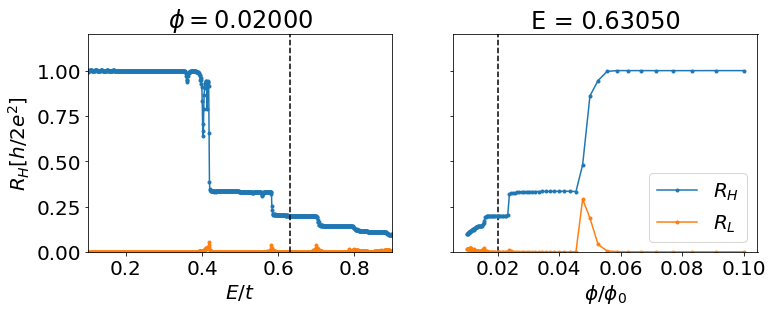

In [13]:
# Plot the results
E_idx = 630
phi_idx = 40
plt.rcParams.update({'font.size':20})
fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,4))
axs[0].set_title('$\phi = {:.5f}$'.format(1/rec_phis[phi_idx]))
axs[0].plot(E, RH[phi_idx,:], '.-', label='$R_{H}$')
axs[0].plot(E, RL[phi_idx,:], '.-', label='$R_{L}$')
axs[0].axvline(x=E[E_idx], ls='--', c='k')
axs[0].set_ylim(0,1.2)
axs[0].set_xlim(0.1,0.9)
axs[1].set_title(f'E = {E[E_idx]:.5f}')
axs[1].axvline(x=1/rec_phis[phi_idx], ls='--', c='k')
axs[1].plot(1/rec_phis, RH[:,E_idx], '.-', label='$R_{H}$')
axs[1].plot(1/rec_phis, RL[:,E_idx], '.-', label='$R_{L}$')

# secax = axs[1].secondary_yaxis('right')#, functions=(lambda y: 0.1*y, lambda y: 10*y))

axs[0].set_ylabel(r'$R_H \left[h/2e^2\right]$')
axs[0].set_xlabel('$E/t$')
axs[1].set_xlabel('$\phi/\phi_0$')
# secax.set_ylabel(r'$R_L \left[h/2e^2\right]$')

axs[1].legend()
plt.show()